In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys

import seaborn as sns

# Definir carpetas y archivos a utilizar
---
Arbol de archivos
```bash
 root
 ├───Codigos Python
 ├───Datos
 |   ├───Datos_CEN: Informacion de generacion historica en archivos .tsv para cada mes. Fuente:
 |   ├───Capacidad Instalada.xlsx: Informacion de capacidad instalada para cada mes. Fuente:
 |   └───Coordenadas.xlsx: Informacion de ubicacion geografica de centrales. Fuente:
 ├───Figuras: Carpeta que contiene las figuras de los codigos
 └───Output: Carpeta que contiene salidas de los programas, ejemplo: generación por cluster
 ```

In [2]:
Hidro = True

In [3]:
root_dir = os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd())))

# Directorios principales
Estudio_Principal_dir = os.path.join(root_dir, 'a. Estudio Principal')
ProcesamientoDatos_dir = os.path.join(Estudio_Principal_dir, 'a. Procesamiento de datos')
Estudios_dir = os.path.join(Estudio_Principal_dir, 'b. Estudios preliminares Sistema')

# Datos de entrada
DatosEntrada_dir = os.path.join(root_dir, '1. Datos de entrada')
GenData_dir = os.path.join(DatosEntrada_dir, 'Generacion')
datosCEN_dir = os.path.join(GenData_dir, 'Datos_CEN')

# Datos de generacion procesados
DatosProcesados_dir = os.path.join(ProcesamientoDatos_dir, 'Output')

# Capacidad Instalada CEN
Capacidad_Instalada_file = os.path.join(GenData_dir,'Capacidad_Instalada.xlsx')
df_CapacidadInst = pd.read_excel(Capacidad_Instalada_file, sheet_name='Capacidad')  # Se lee el archivo de capacidad instalada

# Reporte de centrales
reporteCentrales_file = os.path.join(GenData_dir, 'reporte_centrales.xlsx')
df_Reporte = pd.read_excel(reporteCentrales_file, sheet_name='Centrales', skiprows=6)

# Directorios de procesamiento de datos
Figuras_dir = os.path.join(Estudios_dir, 'Figuras')

#Crear las carpetas que no existan
if not os.path.exists(Figuras_dir): os.makedirs(Figuras_dir)

In [4]:
# Parametros de entrada (deben ser modificados dependiendo de los años a analizar)
years = [2020,2021,2022,2023,2024]  # Vector con los años a analizar
last_year_month = 6  # Mes del último año a analizar, si se tiene el año completo utilizar 12

# Parametros fijos
last_day = {'01':31,'02':28,'03':31,'04':30,'05':31,'06':30,'07':31,'08':31,'09':30,'10':31,'11':30,'12':31}
Años_bisiestos = [2020,2024,2028,2032,2036,2040,2044,2048,2052,2056,2060]  # Años bisiestos
meses = ['enero','febrero','marzo','abril','mayo','junio','julio','agosto','septiembre','octubre','noviembre','diciembre']  # Vector con los meses del año
months_numbers = {'enero':'01','febrero':'02','marzo':'03','abril':'04','mayo':'05','junio':'06','julio':'07','agosto':'08','septiembre':'09','octubre':'10','noviembre':'11','diciembre':'12'}  # Diccionario que relaciona el nombre del mes con su número
numbers_months = {1:'Enero',2:'Febrero',3:'Marzo',4:'Abril',5:'Mayo',6:'Junio',7:'Julio',8:'Agosto',9:'Septiembre',10:'Octubre',11:'Noviembre',12:'Diciembre'}  # Diccionario que relaciona el número del mes con su nombre

In [5]:
def cargar_dataset(Data_dir):
    df_sol_data = pd.read_parquet(os.path.join(Data_dir, 'df_sol_data.parquet'))
    df_eol_data = pd.read_parquet(os.path.join(Data_dir, 'df_eol_data.parquet'))
    df_hid_data = pd.read_parquet(os.path.join(Data_dir, 'df_hid_data.parquet'))

    df_PotenciaSistema = pd.read_parquet(os.path.join(Data_dir, 'df_PotenciaSistema.parquet'))

    df_sol_info = pd.read_excel(os.path.join(Data_dir, 'df_GenInfo.xlsx'), sheet_name='Solar')
    df_eol_info = pd.read_excel(os.path.join(Data_dir, 'df_GenInfo.xlsx'), sheet_name='Eolica')
    df_hid_info = pd.read_excel(os.path.join(Data_dir, 'df_GenInfo.xlsx'), sheet_name='Hidro')

    df_tech_data = [df_sol_data, df_eol_data, df_hid_data]
    df_tech_info = [df_sol_info, df_eol_info, df_hid_info]

    return df_tech_data, df_tech_info, df_PotenciaSistema

def getGenSistema(dfs_data,columnas):
    dfs = []
    for df,column in zip(dfs_data,columnas):
        df_gen = df.set_index(["Year","Month","Day","Hour"]).sum(axis=1).to_frame().reset_index().rename(columns={0:column})
        dfs.append(df_gen[column])
    df_gen_sistema = pd.concat(dfs,axis=1)
    df_YearMonthDayHour = dfs_data[0][["Year","Month","Day","Hour"]]
    df_gen_sistema = pd.concat([df_YearMonthDayHour,df_gen_sistema],axis=1)
    return df_gen_sistema

In [6]:
[df_sol_data, df_eol_data, df_hid_data], [df_sol_info, df_eol_info, df_hid_info], df_PotenciaSistema = cargar_dataset(DatosProcesados_dir)

if Hidro:
    df_GenSistema = getGenSistema([df_sol_data, df_eol_data, df_hid_data],['Solar','Eolica','Hidro'])
    dfs_GenCentrales = {"Solar": df_sol_data,
                        "Eolica": df_eol_data,
                        "Hidro": df_hid_data}
else:
    df_GenSistema = getGenSistema([df_sol_data, df_eol_data],['Solar','Eolica'])
    dfs_GenCentrales = {"Solar": df_sol_data,
                        "Eolica": df_eol_data}
    df_CapacidadInst = df_CapacidadInst.drop('Hidro',axis=1)

### Metodologia para calculo de CapacidadMensual efectiva
---
En orden de calcular la capacidad instalada mensual efectiva del sistema lo que se utiliza es el máximo de generación reportada al coordinador, este máximo es comparado con los máximos en meses anteriores a modo de evitar considerar un máximo inferior al reportado para la central

In [7]:
def calcular_CapacidadMensual(dfs_GenCentrales: pd.DataFrame):
    dfs = []
    for key,df_tech_data in dfs_GenCentrales.items():
        Years = []
        Months = []
        PotMaxs = []

        Pot_Max = 0 # Potencia máxima reportada hasta el momento
        for year in df_tech_data['Year'].unique():
            df_tech_data_year = df_tech_data[df_tech_data['Year']==year]
            for month in df_tech_data_year['Month'].unique():
                df_tech_data_year_month = df_tech_data_year[df_tech_data_year['Month']==month]

                # Calcular la capacidad máxima reportada en el mes
                Pot_Max_Month = df_tech_data_year_month.iloc[:,4:].max(axis=0)
                Pot_Max_Month = Pot_Max_Month.dropna(axis=0,how='all')
                Pot_Max_Month = Pot_Max_Month.sum()

                # Comparar con la capacidad máxima reportada hasta el momento, si es mayor se actualiza
                # en caso contrario se mantiene el valor
                if Pot_Max_Month>Pot_Max:
                    Pot_Max = Pot_Max_Month

                # Se agrega la capacidad máxima reportada en el mes al vector de capacidades máximas, así como el año y mes
                Years.append(year)
                Months.append(month)
                PotMaxs.append(Pot_Max)

        # Se crea un dataframe con la capacidad máxima reportada en cada mes
        df = pd.DataFrame({'Year':Years,'Month':Months,key:PotMaxs})
        df.set_index(['Year','Month'],inplace=True)
        dfs.append(df)
    df_CapacidadMensual = pd.concat(dfs,axis=1)
    df_CapacidadMensual = df_CapacidadMensual.reset_index()
    return df_CapacidadMensual

def calcular_CapacidadMensual_v2(dfs_GenCentrales: pd.DataFrame):
    dfs = []
    for key,df_tech_data in dfs_GenCentrales.items():
        Years = []
        Months = []
        PotMaxs = []

        Pot_Max = 0 # Potencia máxima reportada hasta el momento
        for year in df_tech_data['Year'].unique():
            df_tech_data_year = df_tech_data[df_tech_data['Year']==year]
            for month in df_tech_data_year['Month'].unique():
                df_tech_data_year_month = df_tech_data_year[df_tech_data_year['Month']<=month]

                # Calcular la capacidad máxima reportada en el mes
                Pot_Max_Month = df_tech_data_year_month.iloc[:,4:].max(axis=0)
                Pot_Max_Month = Pot_Max_Month.dropna(axis=0,how='all')
                Pot_Max_Month = Pot_Max_Month.sum()

                # Comparar con la capacidad máxima reportada hasta el momento, si es mayor se actualiza
                # en caso contrario se mantiene el valor
                if Pot_Max_Month>Pot_Max:
                    Pot_Max = Pot_Max_Month

                # Se agrega la capacidad máxima reportada en el mes al vector de capacidades máximas, así como el año y mes
                Years.append(year)
                Months.append(month)
                PotMaxs.append(Pot_Max_Month)

        # Se crea un dataframe con la capacidad máxima reportada en cada mes
        df = pd.DataFrame({'Year':Years,'Month':Months,key:PotMaxs})
        df.set_index(['Year','Month'],inplace=True)
        dfs.append(df)
    df_CapacidadMensual = pd.concat(dfs,axis=1)
    df_CapacidadMensual = df_CapacidadMensual.reset_index()
    return df_CapacidadMensual

df_CapSistema_Month = calcular_CapacidadMensual_v2(dfs_GenCentrales)

# Hidrología

In [8]:
# Seleccionar todas las centrales que contengan HP en su nombre
df_HidPasada_raw = df_Reporte[df_Reporte['Nombre'].str.contains('HP')]
df_HidPasada_raw = df_HidPasada_raw.loc[:, ['Nombre','11.1.11 Fecha de entrada en operación','11.1.4 Potencia máxima bruta, para cada tipo de combustible que pueda operar','Estado (operativa/en pruebas/en construcción)']].copy()
df_HidPasada_raw.rename(columns={'11.1.11 Fecha de entrada en operación':'Fecha', '11.1.4 Potencia máxima bruta, para cada tipo de combustible que pueda operar':'Potencia','Estado (operativa/en pruebas/en construcción)':'Estado'}, inplace=True)

"""
# Seleccionar todas las centrales que contengan PFV en su nombre
df_FotVol_raw = df_Reporte[df_Reporte['Nombre'].str.contains('PFV')]
df_FotVol_raw = df_FotVol_raw.loc[:, ['Nombre','11.1.11 Fecha de entrada en operación','11.1.4 Potencia máxima bruta, para cada tipo de combustible que pueda operar','Estado (operativa/en pruebas/en construcción)']].copy()
df_FotVol_raw.rename(columns={'11.1.11 Fecha de entrada en operación':'Fecha', '11.1.4 Potencia máxima bruta, para cada tipo de combustible que pueda operar':'Potencia','Estado (operativa/en pruebas/en construcción)':'Estado'}, inplace=True)

# Seleccionar todas las centrales con formato de fecha solo año, por ejemplo Fecha = 2010
df_FotVol_FormatoYear = df_FotVol_raw[df_FotVol_raw['Fecha'].astype(str).str.len() == 4].copy()

# Seleccionar todas las centrales con formato de fecha año-mes-dia, por ejemplo Fecha = 2010-01-01
df_FotVol_FormatoYearMesDia = df_FotVol_raw[df_FotVol_raw['Fecha'].astype(str).str.len() == 10].copy()
df_FotVol_FormatoYearMesDia['Fecha'] = df_FotVol_FormatoYearMesDia['Fecha'].str.replace('/','-')

# Seleccionar todas las centrales con formato que no sea año o año-mes-dia
df_FotVol_FormatoAnomalo = df_FotVol_raw[(df_FotVol_raw['Fecha'].astype(str).str.len() != 4) & (df_FotVol_raw['Fecha'].astype(str).str.len() != 10)].copy()

df_FotVol_FormatoYear["Fecha"] = pd.to_datetime(df_FotVol_FormatoYear["Fecha"], format="%Y")
df_FotVol_FormatoYearMesDia["Fecha"] = pd.to_datetime(df_FotVol_FormatoYearMesDia["Fecha"], format="%d-%m-%Y")
df_FotVol_FormatoAnomalo["Fecha"] = pd.to_datetime(df_FotVol_FormatoAnomalo["Fecha"])

# Unir los dos dataframes
df_FotVol = pd.concat([df_FotVol_FormatoYear, df_FotVol_FormatoYearMesDia, df_FotVol_FormatoAnomalo], ignore_index=True)
"""

# Seleccionar todas las centrales con formato de fecha solo año, por ejemplo Fecha = 2010
df_HidPasada_FormatoYear = df_HidPasada_raw[df_HidPasada_raw['Fecha'].astype(str).str.len() == 4].copy()

# Selección de las centrales con formato de fecha año-mes-dia, por ejemplo Fecha = 2010-01-01
df_HidPasada_FormatoYearMesDia = df_HidPasada_raw[df_HidPasada_raw['Fecha'].astype(str).str.len() == 10].copy()

# Seleccionar todas las centrales con formato que no sea año o año-mes-dia
df_HidPasada_FormatoAnomalo = df_HidPasada_raw[(df_HidPasada_raw['Fecha'].astype(str).str.len() != 4) & (df_HidPasada_raw['Fecha'].astype(str).str.len() != 10)].copy()

Hid_Anomalas = {'PMGD HP LOS MORROS':'1994-01-01',
                'HP MAITENES':'1989-01-01',
                'HP QUILLECO':'2007-05-28',
                'HP PUNTILLA':'2006-01-01',
                'HP ABANICO':'1959-01-01',
                'HP ISLA':'1964-01-01',
                'HP LOS QUILOS':'1989-01-01',
                'PMGD HP LOS PORTONES':'2020-06-09',
                'HP ALFALFAL II':'2022-04-14',
                'HP CUMBRES':'2019-09-28'}

for key,value in Hid_Anomalas.items():
    df_HidPasada_FormatoAnomalo.loc[df_HidPasada_FormatoAnomalo['Nombre']==key,'Fecha'] = value

df_HidPasada_FormatoYear["Fecha"] = pd.to_datetime(df_HidPasada_FormatoYear["Fecha"], format="%Y")
df_HidPasada_FormatoYearMesDia["Fecha"] = pd.to_datetime(df_HidPasada_FormatoYearMesDia["Fecha"], format="%d-%m-%Y")
df_HidPasada_FormatoAnomalo["Fecha"] = pd.to_datetime(df_HidPasada_FormatoAnomalo["Fecha"])

# Unir los dos dataframes
df_HidPasada = pd.concat([df_HidPasada_FormatoYear, df_HidPasada_FormatoYearMesDia, df_HidPasada_FormatoAnomalo], ignore_index=True)

def CalcularPotenciaInstalada(df_input, year, month):
    """
    Esta función calcula la potencia instalada de las centrales hidroeléctricas que estaban en operación en el año y mes especificado.
    """
    df = df_input.copy()
    df = df[df['Fecha'] <= pd.to_datetime(f'{year}-{month}-01', format='%Y-%m-%d')]

    # Seleccionar todas las centrales que estaban en operación en el año y mes especificado
    df = df[df['Estado'] == 'Operativa'].copy()
    return df['Potencia'].sum()

def BuscarCentralesInstaldas(df_input,year,month):
    """
    Esta función busca las centrales hidroeléctricas que entraron en operación en el año y mes especificado.
    """
    df = df_input.copy()
    df = df[df['Fecha'] >= pd.to_datetime(f'{year}-{month}-01', format='%Y-%m-%d') - pd.DateOffset(months=1)]

    if month == 12:
        year = year + 1
        month = 1
    else:
        month = month + 1
    df = df[df['Fecha'] <= pd.to_datetime(f'{year}-{month}-01', format='%Y-%m-%d')]

    return df

p_hid = {}
for year in years:
    p_hid[year] = {}
    if year == years[-1]:
        last_month = last_year_month
    else:
        last_month = 12

    for month in range(1, last_month+1):
        print(f'El {year}-{month} la potencia instalada es {CalcularPotenciaInstalada(df_HidPasada, year, month)}')
        p_hid[year][month] = CalcularPotenciaInstalada(df_HidPasada, year, month)

El 2020-1 la potencia instalada es 2670.6653
El 2020-2 la potencia instalada es 2670.6653
El 2020-3 la potencia instalada es 2670.6653
El 2020-4 la potencia instalada es 2671.1653
El 2020-5 la potencia instalada es 2671.1653
El 2020-6 la potencia instalada es 2673.7253
El 2020-7 la potencia instalada es 2693.0903
El 2020-8 la potencia instalada es 2693.0903
El 2020-9 la potencia instalada es 2693.0903
El 2020-10 la potencia instalada es 2693.0903
El 2020-11 la potencia instalada es 2693.0903
El 2020-12 la potencia instalada es 2694.5913
El 2021-1 la potencia instalada es 2694.5913
El 2021-2 la potencia instalada es 2709.4913
El 2021-3 la potencia instalada es 2709.4913
El 2021-4 la potencia instalada es 2709.4913
El 2021-5 la potencia instalada es 2709.4913
El 2021-6 la potencia instalada es 2731.9913
El 2021-7 la potencia instalada es 2731.9913
El 2021-8 la potencia instalada es 2731.9913
El 2021-9 la potencia instalada es 2731.9913
El 2021-10 la potencia instalada es 2731.9913
El 202

In [9]:
# Reemplazar los valores de potencia instalada en el dataframe de capacidad mensual
if Hidro:
    df_CapacidadInst['Hidro'] = df_CapacidadInst.apply(lambda x: int(round(p_hid[x['Year']][x['Month']],0)), axis=1)

# Graficar
---

In [10]:
if Hidro:
    colors = {'Eólico':"#a8acb0",'Solar FV':"#ee9f20",'Hidro':"#5b97ca"}
else:
    colors = {'Eólico':"#5b97ca",'Solar FV':"#ee9f20"}

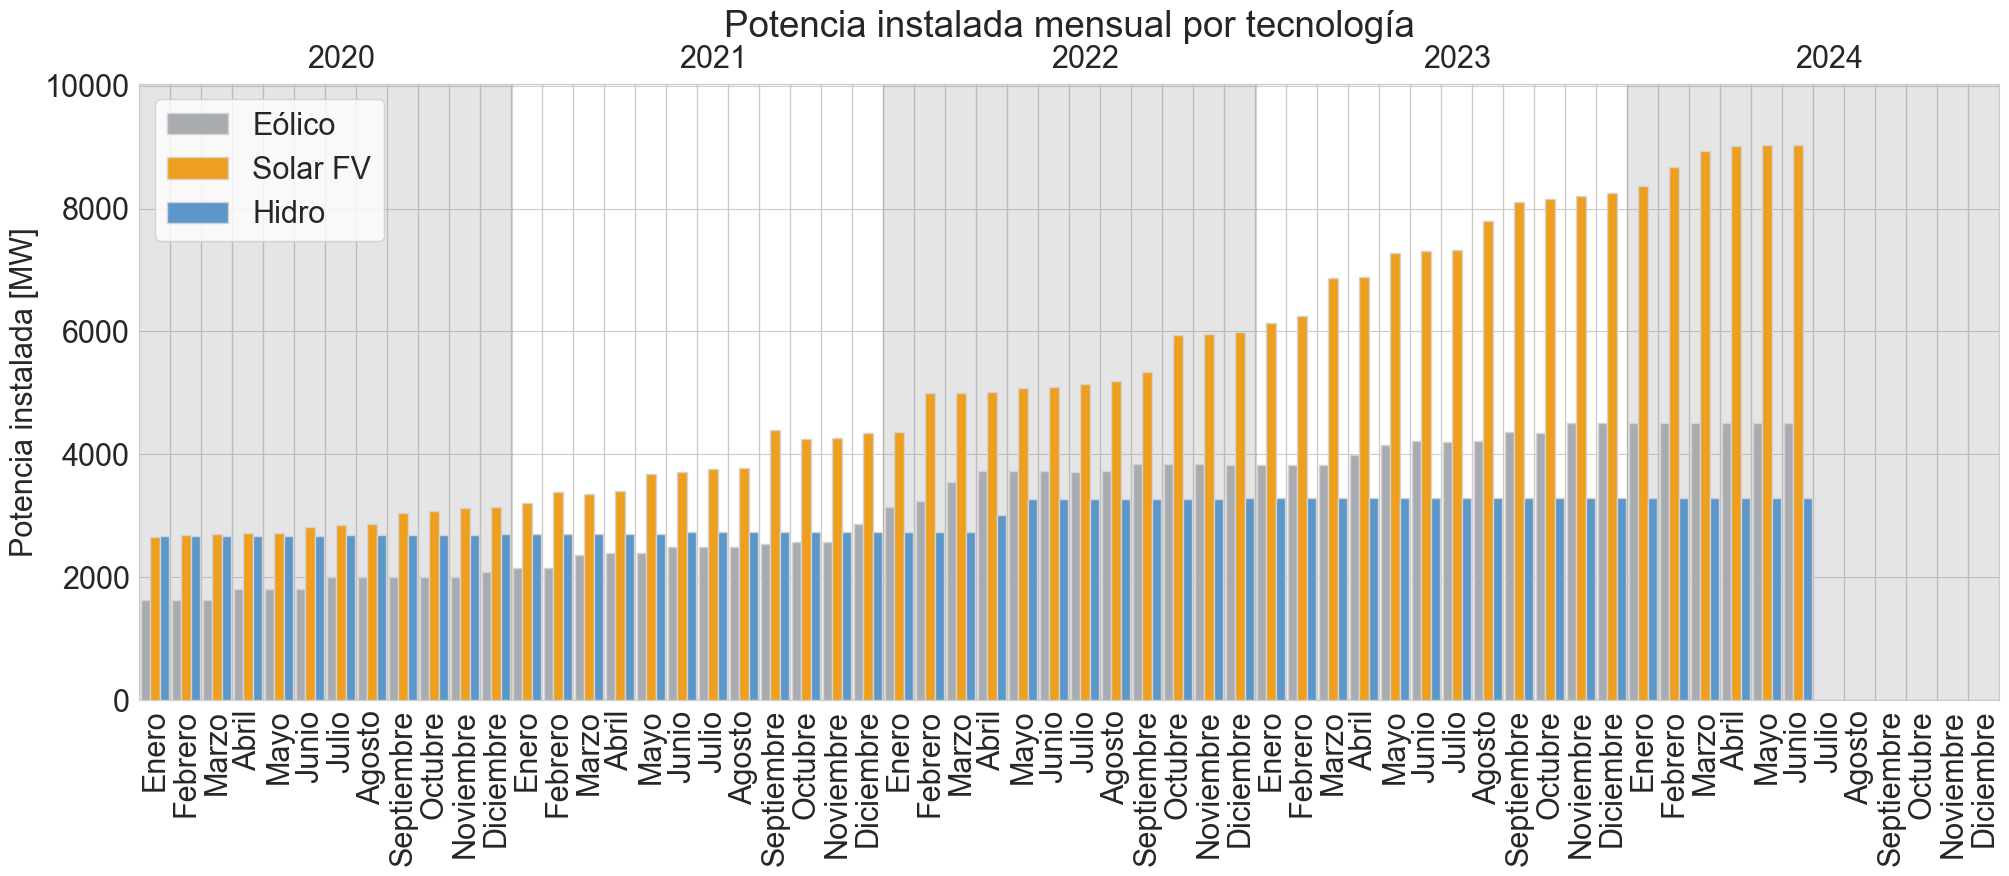

In [11]:
def graficar_Capacidad(df_CapSistema_Month, save_folder):

    # Revisar si el ultimo año tiene todos los meses, en caso contrario se agregan los meses faltantes
    # con una capacidad de 0

    last_year = df_CapSistema_Month['Year'].unique()[-1]
    last_month = df_CapSistema_Month[df_CapSistema_Month['Year']==last_year]['Month'].unique()[-1]
    if last_month<12:
        dfs_append = [df_CapSistema_Month]
        columns = df_CapSistema_Month.columns
        for month in range(last_month+1,13):
            df_append = pd.DataFrame([[last_year,month]+[0]*len(columns[2:])],columns=columns)
            dfs_append.append(df_append)
        df_CapSistema_Month = pd.concat(dfs_append)
            
    Cap_eol = df_CapSistema_Month['Eolica'].values
    Cap_solar = df_CapSistema_Month['Solar'].values
    if Hidro: Cap_hidro = df_CapSistema_Month['Hidro'].values

    if Hidro: 
        max_cap = max(max(Cap_eol),max(Cap_solar),max(Cap_hidro))
    else:
        max_cap = max(max(Cap_eol),max(Cap_solar))
    y_lim = (0,max_cap+1000)

    sns.set_style("whitegrid")

    # Cambiar el tamaño de la fuente
    plt.rcParams.update({'font.size': 22})
    years = list(df_CapSistema_Month.Year.unique())
    meses = list(df_CapSistema_Month.Month.unique())

    meses = [numbers_months[mes] for mes in meses]

    n_years = len(years)
    n_meses = n_years*12

    x_axis = np.arange(n_meses)
    meses = meses*n_years

    # Se grafican los factores de planta mensuales calculados
    fig,ax = plt.subplots(figsize=(24,8))

    for i in range(1,n_years+1):
        idx = i-1
        if idx%2==0:
            rango = [(idx/2)*24-0.5,11.525+24*(idx/2)]
            plt.fill_between(rango, 0, y_lim[1], color='gray', alpha=0.2)

    for i in range(1,n_years):
        plt.vlines(i*12-0.5, 0, 1, color='k', linestyle='--', linewidth=1)
    
    if Hidro:
        plt.bar(x_axis-0.3, Cap_eol, 0.3, label='Eólico', color=colors['Eólico'], edgecolor='lightgray')
        plt.bar(x_axis, Cap_solar, 0.3, label='Solar FV', color=colors['Solar FV'], edgecolor='lightgray')
        plt.bar(x_axis+0.3, Cap_hidro, 0.3, label='Hidro', color=colors['Hidro'], edgecolor='lightgray')
    else:
        plt.bar(x_axis-0.15, Cap_eol, 0.3, label='Eólico', color=colors['Eólico'])
        plt.bar(x_axis+0.15, Cap_solar, 0.3, label='Solar FV', color=colors['Solar FV'])

    secx = ax.secondary_xaxis('top')
    secx.set_xticks(np.arange(6, n_meses-6+1, 12))
    secx.set_xticklabels(years)
    secx.tick_params(top = False)

    meses_cap = [mes.capitalize() for mes in meses]
    plt.xticks(x_axis, meses_cap, rotation=90)
    plt.xlim(-0.5,n_meses-0.5)

    # Guardar valores de ylim
    plt.ylim(y_lim)

    plt.ylabel('Potencia instalada [MW]')
    plt.legend(loc='upper left')

    ax.set_xticks(x_axis+0.5,minor=True)
    ax.grid(which='minor', axis='x', linestyle='-', linewidth=1)
    ax.grid(which='major', axis='x', linestyle='-', linewidth=0)

    plt.title(f'Potencia instalada mensual por tecnología')

    if Hidro:
        save_fig = os.path.join(save_folder, f'CapacidadTecnologias.pdf')
    else:
        save_fig = os.path.join(save_folder, f'CapacidadTecnologias_SinHidro.png')
    fig.savefig(save_fig, dpi=300, bbox_inches="tight", format='pdf')

save_folder = os.path.join(Figuras_dir,"Capacidad Tecnologias 3D")
if not os.path.exists(save_folder): os.makedirs(save_folder)

graficar_Capacidad(df_CapacidadInst, save_folder)

# Exportar Capacidad

In [13]:
# Exportar la capacidad instalada mensual
Output_dir = os.path.join(Estudios_dir, 'Output')
if not os.path.exists(Output_dir): os.makedirs(Output_dir)

df_CapacidadInst.to_csv(os.path.join(Output_dir, 'CapacidadInstalada.csv'), index=False)